In [98]:
# Import library yang diperlukan
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix

In [99]:
# Load data ke dalam data frame dan spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('sentimen_no stopword-no stemming_terpisah.csv', encoding='latin-1') 

df.head()

,review_tokens,Sentimen,sentimen,classified_text,tweet_text,sentence_score,max_positive,max_negative,kelas
0,kecewa banget saya pesan yang free pouch tapi ...,Negatif,{'classified_text': 'kecewa [-4] banget saya p...,kecewa [-4] banget saya pesan yang free pouch ...,kecewa banget saya pesan yang free pouch tapi...,['kecewa [-4] banget saya pesan yang free pouc...,5,-4,positif
1,kali ini pengemasan tidak safe sepertinya tutu...,Negatif,{'classified_text': 'kali ini pengemasan tidak...,kali ini pengemasan tidak safe sepertinya tutu...,kali ini pengemasan tidak safe sepertinya tut...,['kali ini pengemasan tidak safe sepertinya tu...,4,-3,positif
2,paket datangnya barang sudah pecah dan saya re...,Negatif,{'classified_text': 'paket datangnya barang su...,paket datangnya barang sudah pecah [-2] dan sa...,paket datangnya barang sudah pecah dan saya r...,['paket datangnya barang sudah pecah [-2] dan ...,1,-4,negatif
3,enggak ada sabun nya enggak sesuai deskripsi,Negatif,{'classified_text': 'enggak ada sabun nya engg...,enggak ada sabun nya enggak sesuai [-3] deskripsi,enggak ada sabun nya enggak sesuai deskripsi,['enggak ada sabun nya enggak sesuai [-3] desk...,1,-3,negatif
4,enggak sesuai harapan,Negatif,{'classified_text': 'enggak sesuai [-3] harapa...,enggak sesuai [-3] harapan [4],enggak sesuai harapan,['enggak sesuai [-3] harapan [4]'],4,-3,positif


In [100]:
# Drop 3 kolom terakhir yang tidak digunakan dengan fungsi iloc
df = df.drop(df.iloc[:,1:8], axis=1)

# Cek data teratas
df.head()

,review_tokens,kelas
0,kecewa banget saya pesan yang free pouch tapi ...,positif
1,kali ini pengemasan tidak safe sepertinya tutu...,positif
2,paket datangnya barang sudah pecah dan saya re...,negatif
3,enggak ada sabun nya enggak sesuai deskripsi,negatif
4,enggak sesuai harapan,positif


In [101]:
# Data untuk rename kolom v1 dan v2
new_cols = {
    'review_tokens' : 'Review',
    'kelas' : 'Sentimen'
}

# Rename nama kolom v1 dan v2
df = df.rename(columns=new_cols)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget saya pesan yang free pouch tapi ...,positif
1,kali ini pengemasan tidak safe sepertinya tutu...,positif
2,paket datangnya barang sudah pecah dan saya re...,negatif
3,enggak ada sabun nya enggak sesuai deskripsi,negatif
4,enggak sesuai harapan,positif


In [102]:
# Cek jumlah data per kelas
print(df['Sentimen'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

positif    143
netral      60
negatif     44
Name: Sentimen, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    247 non-null    object
 1   Sentimen  247 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB
None


              Review Sentimen
count            247      247
unique           241        3
top     terima kasih  positif
freq               3      143


In [103]:
# Data untuk label
new_labels = {
    'negatif' : 0,
    'netral' : 1,
    'positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentimen'] = df['Sentimen'].map(new_labels)

# Cek data teratas
df.head()

,Review,Sentimen
0,kecewa banget saya pesan yang free pouch tapi ...,2
1,kali ini pengemasan tidak safe sepertinya tutu...,2
2,paket datangnya barang sudah pecah dan saya re...,0
3,enggak ada sabun nya enggak sesuai deskripsi,0
4,enggak sesuai harapan,2


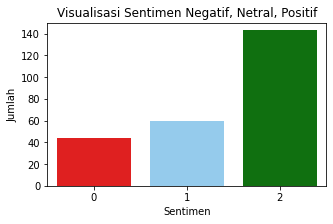

In [104]:
# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Sentimen', palette={0: 'red', 1: 'lightskyblue', 2: 'green'})
plt.title('Visualisasi Sentimen Negatif, Netral, Positif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [105]:
# Memisahkan fitur dengan label
X = df['Review'].values
y = df['Sentimen'].values

In [106]:
# Inisialisasi model
cnb = ComplementNB(alpha=10.0 , fit_prior=True, class_prior=None)

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = KFold(n_splits=10, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()

# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions_testing = []
all_true_labels_testing = []
all_predictions_training = []
all_true_labels_training = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = vectorizer.fit_transform(X_train)
    X_test_transform = vectorizer.transform(X_test)

    # Melatih model klasifikasi pada data latih
    cnb.fit(X_train_transform, y_train)

    # Membuat prediksi pada data uji
    predictions_testing = cnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_testing.extend(predictions_testing)
    all_true_labels_testing.extend(y_test)

    # Membuat prediksi pada data training
    predictions_training = cnb.predict(X_train_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions_training.extend(predictions_training)
    all_true_labels_training.extend(y_train)

In [107]:
# Hitung metrik evaluasi
accuracy_training = accuracy_score(all_true_labels_training, all_predictions_training)
precision_training = precision_score(all_true_labels_training, all_predictions_training, average='weighted')
recall_training = recall_score(all_true_labels_training, all_predictions_training, average='weighted')
f1_training = f1_score(all_true_labels_training, all_predictions_training, average='weighted')

# Print hasil
print("------- AKURASI TRAINING -------")
print("Overall accuracy:", accuracy_training)
print("Overall precision:", precision_training)
print("Overall recall:", recall_training)
print("Overall F1-score:", f1_training)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_training, all_predictions_training)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_training, all_predictions_training, zero_division=0))


------- AKURASI TRAINING -------
Overall accuracy: 0.8389090134242488
Overall precision: 0.863402762206165
Overall recall: 0.8389090134242488
Overall F1-score: 0.8255875756027011
Confusion Matrix : 
 [[ 631    0  205]
 [  95  589  456]
 [   0    0 2717]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.87      0.75      0.81       836
           1       1.00      0.52      0.68      1140
           2       0.80      1.00      0.89      2717

    accuracy                           0.84      4693
   macro avg       0.89      0.76      0.79      4693
weighted avg       0.86      0.84      0.83      4693



In [108]:
# Hitung metrik evaluasi
accuracy_testing = accuracy_score(all_true_labels_testing, all_predictions_testing)
precision_testing = precision_score(all_true_labels_testing, all_predictions_testing, average='weighted')
recall_testing = recall_score(all_true_labels_testing, all_predictions_testing, average='weighted')
f1_testing = f1_score(all_true_labels_testing, all_predictions_testing, average='weighted')

# Print hasil
print("------- AKURASI TESTING -------")
print("Overall accuracy:", accuracy_testing)
print("Overall precision:", precision_testing)
print("Overall recall:", recall_testing)
print("Overall F1-score:", f1_testing)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels_testing, all_predictions_testing)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels_testing, all_predictions_testing, zero_division=0))

------- AKURASI TESTING -------
Overall accuracy: 0.6437246963562753
Overall precision: 0.5889724310776943
Overall recall: 0.6437246963562753
Overall F1-score: 0.5694518347149925
Confusion Matrix : 
 [[ 16   4  24]
 [ 10   5  45]
 [  2   3 138]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.57      0.36      0.44        44
           1       0.42      0.08      0.14        60
           2       0.67      0.97      0.79       143

    accuracy                           0.64       247
   macro avg       0.55      0.47      0.46       247
weighted avg       0.59      0.64      0.57       247



In [109]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = vectorizer.transform([new_text])
predicted_sentimen = cnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  positif
